# Import Libraries and Data
*   직관적인 이해를 위해 MNIST 이미지 데이터를 사용
*   Layer는 기본 AE 실습에 사용한 것과 동일하게 진행


In [ ]:
# VAE에서 KerasTensors와 관련된 문제를 해결하기 위해 2.8 사용
!pip install tensorflow==2.8

In [ ]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, LeakyReLU, Dropout, BatchNormalization, MaxPooling2D, Lambda
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
# MNIST (Class: 0-9) 데이터셋 다운로드
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
X_train = X_train/255
X_test = X_test/255

X_train = X_train.reshape(len(X_train), 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [ ]:
X_train.shape

(60000, 28, 28, 1)

# AE


*   MNIST 데이터를 사용할 수 있도록 input만 변경
*   Encoder, Decoder를 따로 사용할 수 있도록 각각 지정 후 결합



In [ ]:
# 오토인코더 파라미터 지정
encoding_dim = 64
input_shape = X_train.shape[1:]  # (28, 28, 1)

In [ ]:
# ---------------------- Encoder ----------------------
# Input layer
input_layer = Input(shape=input_shape)
flat_input = Flatten()(input_layer)

# Encoding layers
encoded = Dense(encoding_dim, activation='relu')(flat_input)
encoded_output = Dense(int(encoding_dim / 2), activation='relu')(encoded)

# Encoder Model
encoder = Model(inputs=input_layer, outputs=encoded_output, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
Total params: 52,320
Trainable params: 52,320
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# ---------------------- Decoder ----------------------
# Latent space input
latent_input = Input(shape=(int(encoding_dim / 2),))

# Decoding layers
decoded = Dense(int(encoding_dim / 2), activation='relu')(latent_input)
decoded = Dense(np.prod(input_shape), activation='sigmoid')(decoded)
decoded_output = Reshape(input_shape)(decoded)

# Decoder Model
decoder = Model(inputs=latent_input, outputs=decoded_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 784)               25872     
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 26,928
Trainable params: 26,928
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# ---------------------- Autoencoder ----------------------
# Encoder, Decdoer 연결
autoencoder_output = decoder(encoder(input_layer))

# 최종 오토인코더 모델 설정
autoencoder = Model(inputs=input_layer, outputs=autoencoder_output)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 32)                52320     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         26928     
                                                                 
Total params: 79,248
Trainable params: 79,248
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model training
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.1)

Epoch 1/50
211/211 [==============================] - 7s 20ms/step - loss: 0.0738 - val_loss: 0.0459
Epoch 2/50
211/211 [==============================] - 5s 22ms/step - loss: 0.0391 - val_loss: 0.0339
Epoch 3/50
211/211 [==============================] - 5s 25ms/step - loss: 0.0304 - val_loss: 0.0271
Epoch 4/50
211/211 [==============================] - 4s 19ms/step - loss: 0.0253 - val_loss: 0.0236
Epoch 5/50
211/211 [==============================] - 4s 20ms/step - loss: 0.0227 - val_loss: 0.0217
Epoch 6/50
211/211 [==============================] - 6s 26ms/step - loss: 0.0212 - val_loss: 0.0203
Epoch 7/50
211/211 [==============================] - 5s 22ms/step - loss: 0.0200 - val_loss: 0.0194
Epoch 8/50
211/211 [==============================] - 4s 18ms/step - loss: 0.0192 - val_loss: 0.0187
Epoch 9/50
211/211 [==============================] - 4s 18ms/step - loss: 0.0183 - val_loss: 0.0178
Epoch 10/50
211/211 [==============================] - 4s 20ms/step - loss: 0.0176 - val_lo

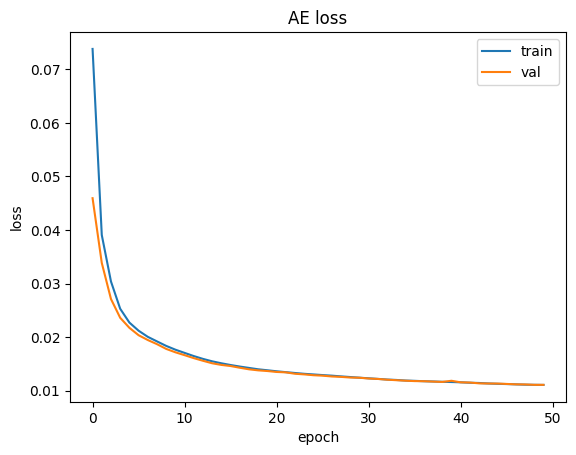

In [ ]:
# AE Loss 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('AE loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right');

## 1. Reconstruction Error 계산

In [ ]:
# X_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 Y_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=(1, 2, 3))  # 이미지 데이터이므로  Axis (1, 2, 3)

error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': np.argmax(Y_test, axis=1)})
error_df.head()


,reconstruction_error,true_class
0,0.004622,7
1,0.013453,2
2,0.002589,1
3,0.009396,0
4,0.011035,4


## 2. Reconstruction Error by Class 시각화
이 코드는 MNIST 데이터셋에 대해 각 숫자 클래스(0-9)의 **재구성 오류(Reconstruction Error)**를 시각화하는 코드입니다.

Autoencoder 모델을 사용한 후, 입력 이미지와 재구성된 이미지 사이의 차이(오차)를 계산하여 이를 시각화하는 데 사용됩니다.

재구성 오류는 모델이 특정 데이터를 얼마나 잘 복원했는지를 나타냅니다. 에러가 낮을수록 잘 생성한 이미지를 의미합니다.

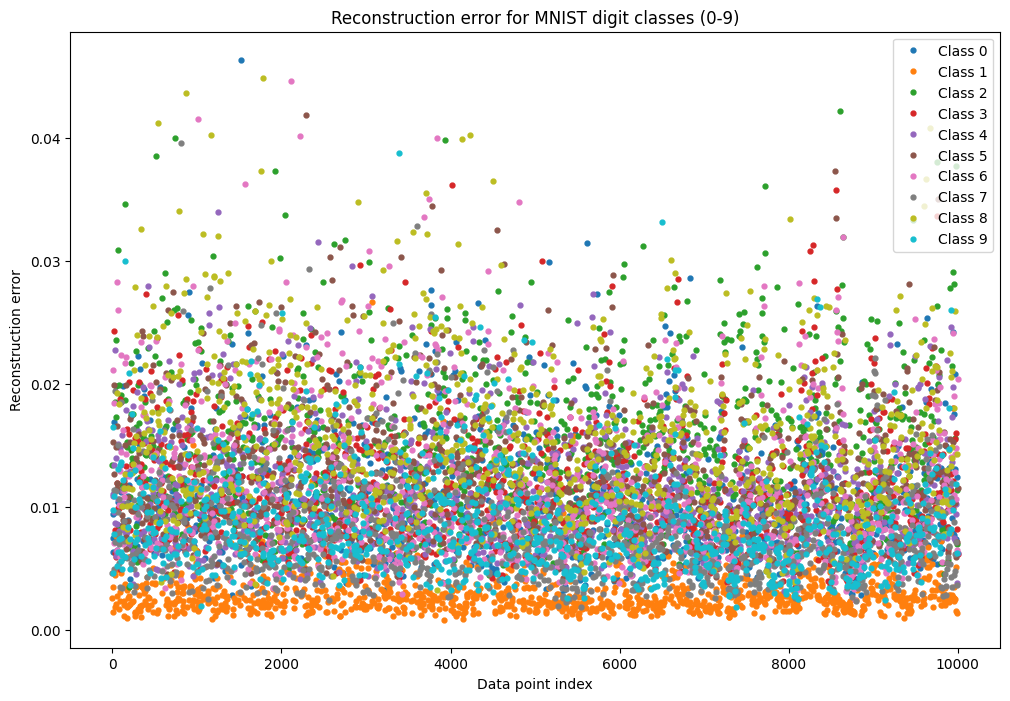

In [ ]:
# 클래스(0-9)에 따른 재구성 오류를 시각화
fig, ax = plt.subplots(figsize=(12, 8))

# 데이터의 실제 클래스(0-9)에 따라 그룹화하고, 재구성 오류를 시각화
groups = error_df.groupby('true_class')
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', linestyle='', ms=3.5,
            label=f"Class {name}")

# 시각화
plt.title('Reconstruction error for MNIST digit classes (0-9)')
plt.xlabel('Data point index')
plt.ylabel('Reconstruction error')
plt.legend(loc='upper right')
plt.show()

## 3. t-SNE를 활용한 VAE 잠재 공간 시각화
이 코드는 Autoencoder의 **잠재 공간(latent space)**을 시각화하기 위해 t-SNE(t-distributed Stochastic Neighbor Embedding) 기법을 사용합니다.

t-SNE는 고차원 데이터를 저차원(보통 2D)으로 축소해 데이터의 군집(클러스터)을 시각적으로 쉽게 볼 수 있게 해주는 차원 축소 기법입니다.

[documentation] https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51104 (\N{HANGUL SYLLABLE JAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

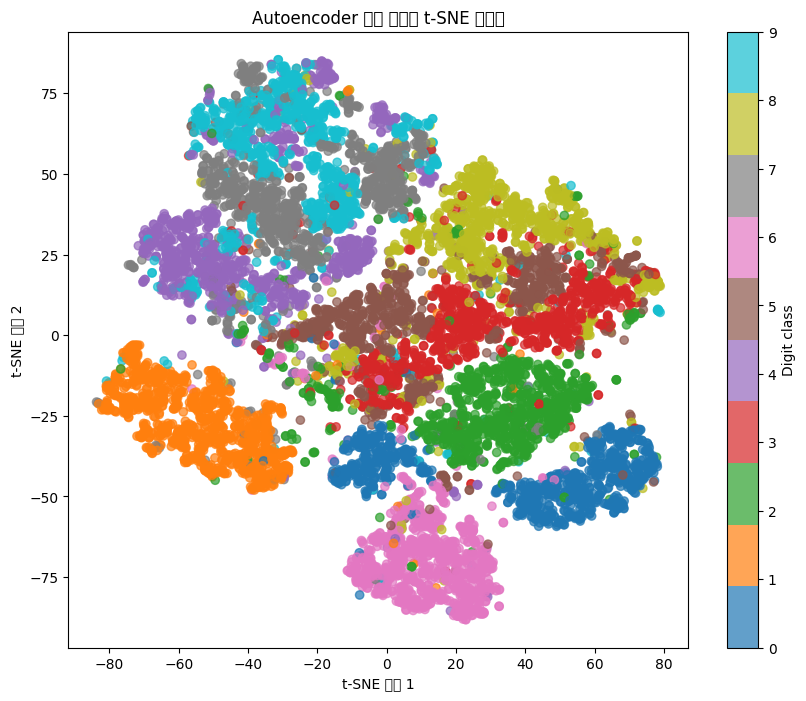

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 인코더에서 잠재 표현(latent representations)을 추출
latent_representations = encoder.predict(X_test)

# t-SNE를 사용해 잠재 차원을 2D로 축소하여 시각화
tsne = TSNE(n_components=2, random_state=42)  # t-SNE 객체 생성, 2개의 차원으로 축소
latent_2d = tsne.fit_transform(latent_representations)  # 잠재 표현을 2D 공간으로 변환

# t-SNE로 변환된 2D 임베딩을 시각화, 각 숫자 클래스(0-9)를 색상으로 구분
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=np.argmax(Y_test, axis=1), cmap='tab10', alpha=0.7)  # 각 클래스에 색상 적용
plt.colorbar(label='Digit class')  # 클래스에 따른 색상 범례 추가
plt.title("Autoencoder 잠재 공간의 t-SNE 시각화")
plt.xlabel("t-SNE 차원 1")  # x축 레이블 설정
plt.ylabel("t-SNE 차원 2")
plt.show()

# VAE

In [ ]:
# Define input shape and latent dimension
input_shape = X_train.shape[1:]  # (28, 28, 1)
latent_dim = 2  # Dimensionality of the latent space

In [ ]:
# ---------------------------------- Encoder ----------------------------------
# Input layer
input_layer = Input(shape=input_shape)
flat_input = Flatten()(input_layer)

# Intermediate encoding layers
encoded = Dense(128, activation='relu')(flat_input)
encoded = Dense(64, activation='relu')(encoded)

# Latent space mean and variance layers
z_mean = Dense(latent_dim, name='z_mean')(encoded)
z_log_var = Dense(latent_dim, name='z_log_var')(encoded)

# Sampling layer using the reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, name='z')([z_mean, z_log_var])

# Encoder model
encoder = Model(inputs=input_layer, outputs=[z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_3[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 128)          100480      ['flatten_1[0][0]']              
                                                                                                  
 dense_5 (Dense)                (None, 64)           8256        ['dense_4[0][0]']                
                                                                                            

In [ ]:
# ---------------------------------- Decoder ----------------------------------
# Latent space input
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

# Intermediate decoding layers
decoder_input = Dense(64, activation='relu')(latent_inputs)
decoder_input = Dense(128, activation='relu')(decoder_input)
decoder_input = Dense(np.prod(input_shape), activation='sigmoid')(decoder_input)  # Output the same size as the flattened input

# Reshape the output to match the original image dimensions
decoded_output = Reshape(input_shape)(decoder_input)

# Decoder model
decoder = Model(inputs=latent_inputs, outputs=decoded_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_6 (Dense)             (None, 64)                192       
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 784)               101136    
                                                                 
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 109,648
Trainable params: 109,648
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# ---------------------------------- VAE Model ----------------------------------
# Use the encoder to generate z_mean, z_log_var, and z
outputs = decoder(z)

# Complete VAE model (encoder + decoder)
vae = Model(inputs=input_layer, outputs=outputs, name='vae')

# Define VAE loss: Reconstruction loss + KL Divergence
reconstruction_loss = K.sum(K.binary_crossentropy(K.flatten(input_layer), K.flatten(outputs)), axis=-1)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(learning_rate=0.001))

# Show the summary of the full VAE model
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_3[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 128)          100480      ['flatten_1[0][0]']              
                                                                                                  
 dense_5 (Dense)                (None, 64)           8256        ['dense_4[0][0]']                
                                                                                                

In [ ]:
# Model training
history = vae.fit(X_train,
                  epochs=50,
                  batch_size=256,
                  shuffle=True,
                  validation_split=0.1)

Epoch 1/50
211/211 [==============================] - 8s 29ms/step - loss: 56303.1719 - val_loss: 45768.5273
Epoch 2/50
211/211 [==============================] - 4s 18ms/step - loss: 45321.3359 - val_loss: 42585.9609
Epoch 3/50
211/211 [==============================] - 4s 18ms/step - loss: 42602.3867 - val_loss: 40299.9336
Epoch 4/50
211/211 [==============================] - 5s 25ms/step - loss: 40784.4844 - val_loss: 38814.0586
Epoch 5/50
211/211 [==============================] - 4s 19ms/step - loss: 39695.6914 - val_loss: 38153.6211
Epoch 6/50
211/211 [==============================] - 4s 18ms/step - loss: 39053.5977 - val_loss: 37647.0234
Epoch 7/50
211/211 [==============================] - 4s 21ms/step - loss: 38554.9844 - val_loss: 37290.3711
Epoch 8/50
211/211 [==============================] - 5s 24ms/step - loss: 38159.8594 - val_loss: 36918.8203
Epoch 9/50
211/211 [==============================] - 4s 18ms/step - loss: 37814.9375 - val_loss: 36593.9883
Epoch 10/50
211/211

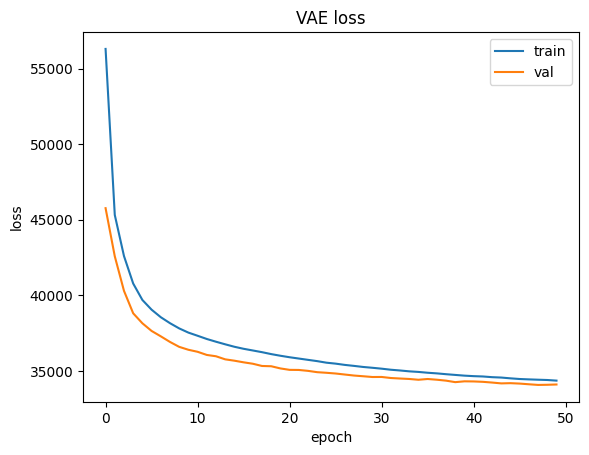

In [ ]:
# VAE Loss 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VAE loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right');
plt.show()

## 1. Reconstruction 시각화
이 함수는 **Autoencoder**와 **Variational Autoencoder (VAE)**로 입력 데이터를 재구성한 결과를 시각적으로 비교하는 역할을 합니다.

원본 이미지와 재구성된 이미지를 나란히 배치하여, 모델이 입력 데이터를 얼마나 잘 복원했는지 쉽게 확인할 수 있습니다.


Autoencoder Reconstructions:


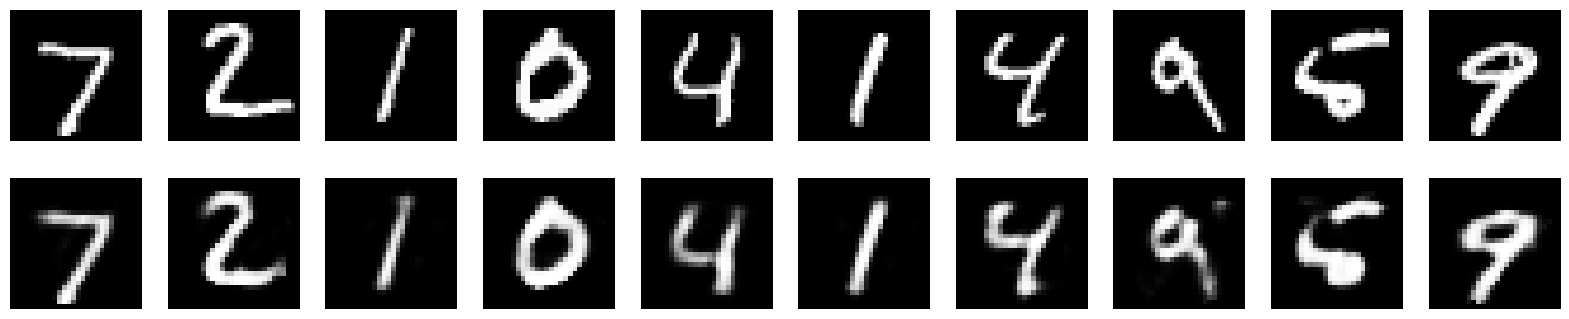

VAE Reconstructions:


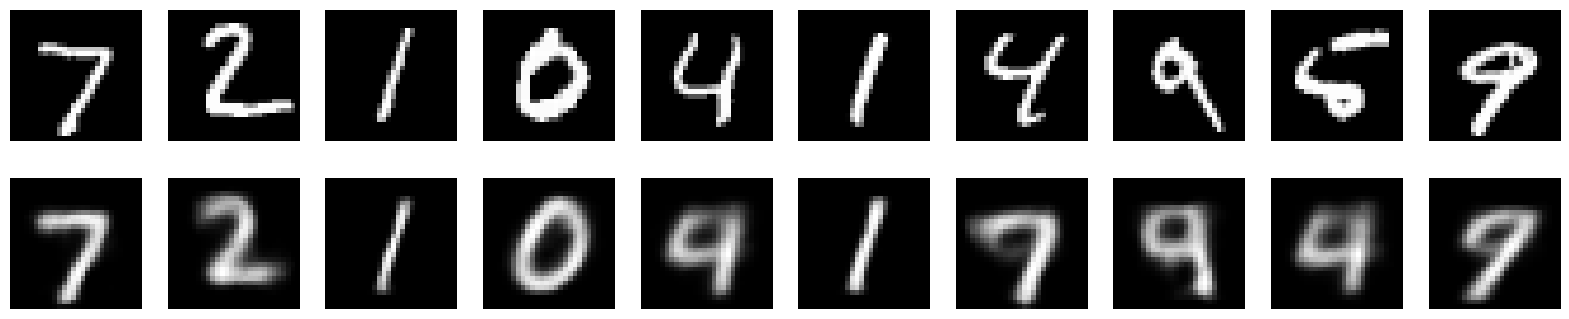

In [ ]:
# Reconstruction 시각화
def plot_reconstructions(model, data, n=10):
    decoded_imgs = model.predict(data[:n])

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # 원본 이미지
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

    plt.show()

# Plot AE reconstructions
print("Autoencoder Reconstructions:")
plot_reconstructions(autoencoder, X_test)

# Plot VAE reconstructions
print("VAE Reconstructions:")
plot_reconstructions(vae, X_test)

## 2. t-SNE를 활용한 VAE 잠재 공간 시각화
이 코드는 **Variational Autoencoder (VAE)**의 잠재 공간을 t-SNE를 사용해 2D로 시각화하는 역할을 합니다.

t-SNE는 고차원 데이터를 저차원(보통 2D)으로 줄여주는 차원 축소 기법으로, 데이터를 시각적으로 이해하기 쉽게 해줍니다.



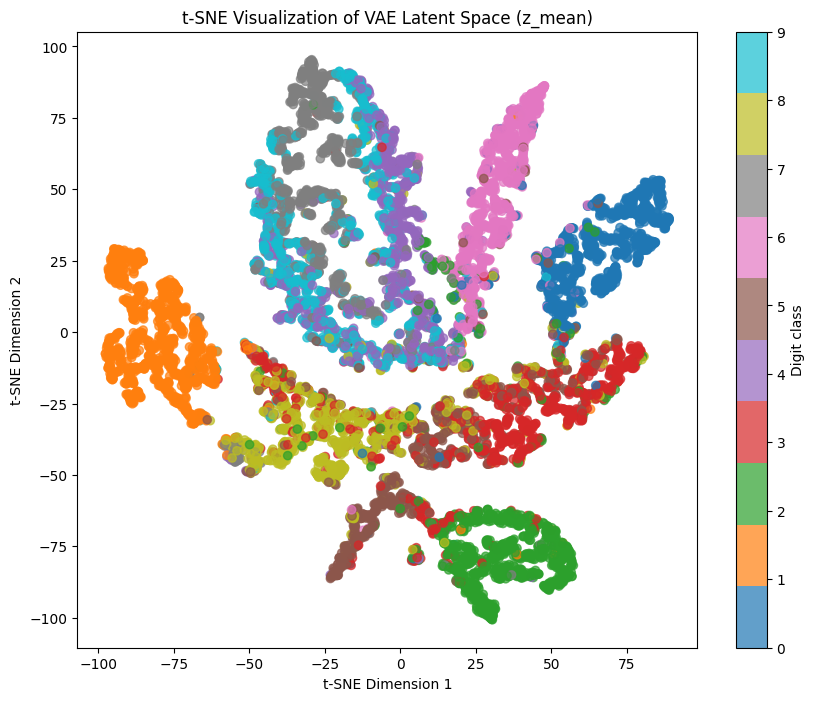

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# encoder.predict(X_test) 코드를 통해 VAE의 encoder에서 잠재 공간의 평균(z_mean)을 추출
z_mean, _, _ = encoder.predict(X_test)

# TSNE 적용 후 잠재 공간을 2차원으로 축소합니다.
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(z_mean)

# t-SNE로 축소된 2D 데이터를 산점도로 표시
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=np.argmax(Y_test, axis=1), cmap='tab10', alpha=0.7)
plt.colorbar(label='Digit class')
plt.title("t-SNE Visualization of VAE Latent Space (z_mean)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

## 3. VAE를 활용한 잠재 공간에서의 샘플링 및 이미지 생성

이 코드는 **Variational Autoencoder (VAE)**의 잠재 공간에서 샘플을 추출하여, 해당 샘플로부터 생성된 MNIST 숫자 이미지를 2D 격자로 시각화하는 역할을 합니다. 이 과정은 VAE가 잠재 공간을 어떻게 학습했는지, 그리고 잠재 공간에서 숫자 데이터를 어떻게 생성할 수 있는지를 보여줍니다.

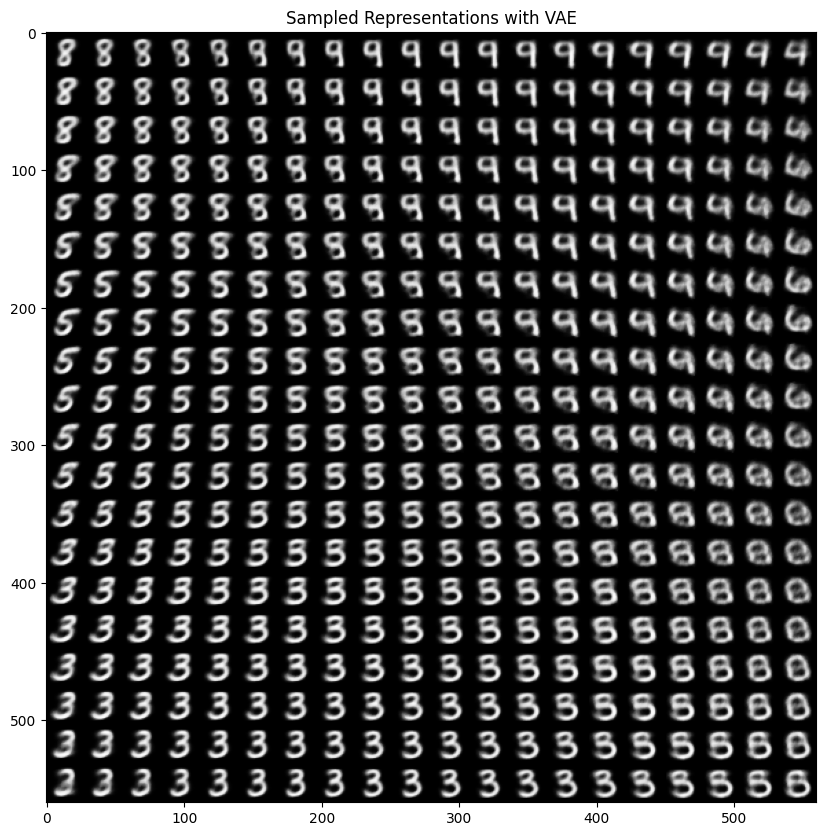

In [ ]:
from scipy.stats import norm  # 정규 분포를 사용하기 위해 scipy에서 norm을 불러옴

# 생성될 그림의 그리드 크기
n = 20  # 각 차원에서 생성될 숫자의 개수 (20x20 격자)
digit_size = 28  # 각 MNIST 숫자는 28x28 크기

# 생성될 숫자 이미지를 담을 빈 figure 생성
figure = np.zeros((digit_size * n, digit_size * n))  # 전체 이미지 크기는 28*20 x 28*20

# 잠재 공간에서 그리드를 정의, 정규 분포의 퍼센트 포인트 함수(ppf)를 사용
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))  # x축에 해당하는 잠재 공간의 샘플링 값들 (분위수)
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))  # y축에 해당하는 잠재 공간의 샘플링 값들 (분위수)

# 잠재 공간 그리드에서 숫자들을 생성
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])  # 그리드에서 (xi, yi)에 해당하는 잠재 벡터 샘플 생성
        x_decoded = decoder.predict(z_sample)  # 디코더를 사용해 잠재 벡터로부터 숫자 이미지 생성
        digit = x_decoded[0].reshape(digit_size, digit_size)  # 생성된 이미지를 28x28로 변형
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit  # 생성된 숫자를 figure의 적절한 위치에 배치

# 2D 잠재 공간에서 샘플링된 숫자 이미지를 시각화
plt.figure(figsize=(10, 10))
plt.title('Sampled Representations with VAE')
plt.imshow(figure, cmap='Greys_r')
plt.show()

## 4. Reconstruction Error 계산 및 시각화

In [ ]:
# X_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 Y_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

predictions = vae.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=(1, 2, 3))  # 이미지 데이터이므로  Axis (1, 2, 3)

error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': np.argmax(Y_test, axis=1)})
error_df.head()

,reconstruction_error,true_class
0,0.017979,7
1,0.062462,2
2,0.004347,1
3,0.034074,0
4,0.028561,4


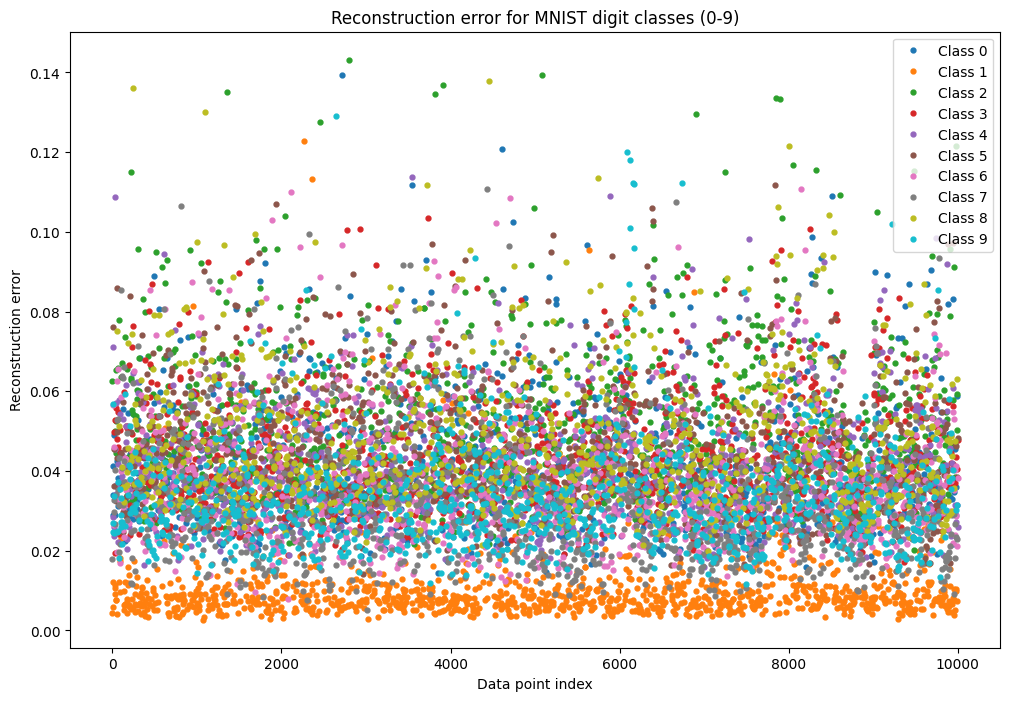

In [ ]:
# 클래스(0-9)에 따른 재구성 오류를 시각화
fig, ax = plt.subplots(figsize=(12, 8))

# 데이터의 실제 클래스(0-9)에 따라 그룹화하고, 재구성 오류를 시각화
groups = error_df.groupby('true_class')
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', linestyle='', ms=3.5,
            label=f"Class {name}")

# 시각화
plt.title('Reconstruction error for MNIST digit classes (0-9)')
plt.xlabel('Data point index')
plt.ylabel('Reconstruction error')
plt.legend(loc='upper right')
plt.show()